# Task 1: Clustering

For this task, the goal is to cluster the users based on their weekday/weekend usage patterns as well as their preferred charging start time.

We'll preform K-means and DBSCAN clustering and compare them.

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
from permetrics import ClusteringMetric
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter


# Example usage
pd.set_option('display.width', 200)  # Adjust the width based on your screen size
pd.set_option('display.max_columns', None)  # Show all columns without truncation


In [83]:
# Load the CSV file
def load_csv(path_dataset):
    # Load data into a DataFrame
    data = pd.read_csv(path_dataset)
    return data


# Load data
path_dataset = "../data/EVChargingStationUsage.csv"
original_data = load_csv(path_dataset)
print(f"Dataset shape: {original_data.shape}\n\n")
original_data.head()
original_data.columns


Dataset shape: (259415, 33)




/tmp/ipykernel_3328/1806374918.py:4: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path_dataset)


Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date', 'Start Time Zone', 'End Date', 'End Time Zone', 'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)', 'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type', 'EVSE ID', 'Address 1', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee', 'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID', 'County', 'System S/N', 'Model Number'],
      dtype='object')

In [84]:
original_data

,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Port Number,Plug Type,EVSE ID,Address 1,City,State/Province,Postal Code,Country,Latitude,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,6.249457,2.625,0.784,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.00,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,0.106588,0.045,0.013,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.00,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,14.951777,6.280,1.876,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.00,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,7.159643,3.007,0.899,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.00,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,1.957765,0.822,0.246,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.00,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259410,PALO ALTO CA / TED THOMPSON #3,0024:B100:0002:9F81,City of Palo Alto,12/31/2020 16:39,PST,12/31/2020 17:14,PST,12/31/2020 17:16,0:35:44,0:35:18,1.841000,0.773,0.231,Level 2,2,J1772,344261.0,275 Cambridge Ave,Palo Alto,California,94306,United States,37.428623,-122.144043,USD,0.42,Plug Out at Vehicle,2369,94301.0,2024201,NaN,1.745410e+11,CT4020-HD-GW
259411,PALO ALTO CA / WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,12/31/2020 16:48,PST,12/31/2020 20:31,PST,12/31/2020 20:32,3:43:01,2:14:04,12.744000,5.352,1.599,Level 2,2,J1772,104427.0,520 Webster St,Palo Alto,California,94301,United States,37.448284,-122.158272,USD,4.69,Plug Out at Vehicle,7255,94541.0,242661,Santa Clara County,1.336410e+11,CT4020-HD-GW
259412,PALO ALTO CA / MPL #4,0024:B100:0003:CD37,City of Palo Alto,12/31/2020 17:28,PST,1/1/2021 10:56,PST,1/1/2021 10:57,17:28:14,5:08:12,29.665000,12.459,3.723,Level 2,1,J1772,2884001.0,3700 Middlefield Rd,Palo Alto,California,94303,United States,37.422104,-122.113510,USD,6.82,Plug Out at Vehicle,455,94306.0,449995,Santa Clara County,2.002410e+11,CT4010-HD-GW
259413,PALO ALTO CA / WEBSTER #1,0024:B100:0002:4233,City of Palo Alto,12/31/2020 17:49,PST,12/31/2020 21:55,PST,12/31/2020 21:56,4:05:34,3:53:42,11.976000,5.030,1.503,Level 2,1,J1772,104427.0,520 Webster St,Palo Alto,California,94301,United States,37.448284,-122.158272,USD,2.75,Plug Out at Vehicle,7256,94552.0,804075,Santa Clara County,1.336410e+11,CT4020-HD-GW


Before we start cleaning the data, let's extract the features we're interested in.

'User ID' and 'Start Date' are required and enough to compute the most common 'Start Time'.

For 'Weekday/Weekend' preference, we could just rely on the 'Day of week' but that wouldn't account for short or long duration charging events. So we need more features.

There's a choice between using 'Energy (kWh)' or 'Charging Time (hh:mm:ss)'.

We choose 'Charging Duration (hh:mm:ss)' because batteries charge a different rates based on several parameters - temperature, current charge level...

Meaning that the average battery will charge much faster 0% to 5% than 95% to 100%.

In this scenario, we're more interested in a users charging station usage than a battery. 

In [85]:
features_df = original_data.copy()


# Use .loc to ensure you are modifying the DataFrame in a safe manner
features_df.loc[:, "Start Date"] = pd.to_datetime(features_df["Start Date"])

# Set the 'Start Date' column as the index
features_df = features_df.set_index("Start Date")
# features_df = features_df[features_df.index.year == 2020]

# Select specific columns
features_df = features_df[["User ID", "Total Duration (hh:mm:ss)"]]

print(features_df.shape)
features_df.head()

(259415, 2)


/home/radugrecu97/dtu/semesters/1/business_analytics/Energy-and-Mobility/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,User ID,Total Duration (hh:mm:ss)
Start Date,,
2011-07-29 20:17:00,3284.0,3:03:32
2011-07-30 00:00:00,4169.0,0:02:06
2011-07-30 08:16:00,4169.0,4:17:32
2011-07-30 14:51:00,2545.0,2:03:24
2011-07-30 18:51:00,3765.0,1:11:24


## Data Cleaning

### NaN Values

Check for NaN values.

In [86]:
def check_nan(df):
    for column in df.columns:
        print(column)
        # Filter the rows where column is NaN
        print(df[df[column].isna()])
        print("\n\n")

check_nan(features_df)

User ID
                    User ID Total Duration (hh:mm:ss)
Start Date                                           
2012-10-13 07:12:00     NaN                   5:36:08
2012-10-13 18:54:00     NaN                   1:24:36
2012-10-14 13:38:00     NaN                   1:01:53
2012-10-14 14:52:00     NaN                   1:08:59
2012-10-14 18:45:00     NaN                   0:19:04
...                     ...                       ...
2020-12-30 14:32:00     NaN                   0:14:41
2020-12-30 17:57:00     NaN                   2:39:12
2020-12-31 11:15:00     NaN                   2:12:09
2020-12-31 11:19:00     NaN                   2:48:41
2020-12-31 14:51:00     NaN                   6:10:05

[7677 rows x 2 columns]



Total Duration (hh:mm:ss)
Empty DataFrame
Columns: [User ID, Total Duration (hh:mm:ss)]
Index: []





Only 'User ID' column has Nan values.

7677 rows consists 2.9% of the total. Since we're interested in targeting individual users in the final model, we choose to drop the NaN entries.

In another case, if we were interested in clustering overall charging station usage, it would make sense to keep these rows as the 'User ID' isn't relevant.

In [87]:
print(features_df.shape)
features_df = features_df.dropna()
print(features_df.shape)

(259415, 2)
(251738, 2)


### Type consistency

In [88]:
def check_dtypes(df):
    # Iterate over all columns in the DataFrame
    for column in df.columns:
        # Get the unique types in the column
        unique_types = df[column].apply(type).unique()
        
        # If the length of unique_types is greater than 1, the column has mixed data types
        if len(unique_types) > 1:
            print(f"The column '{column}' has mixed data types: {unique_types}")
        else:
            print(f"The column '{column}' has a consistent data type: {unique_types[0]}")

check_dtypes(features_df)

The column 'User ID' has mixed data types: [<class 'float'> <class 'str'>]
The column 'Total Duration (hh:mm:ss)' has a consistent data type: <class 'str'>


So it seems 'User ID' has mixed datatypes - floats and strings. Check for non-numeric and numeric strings:

In [89]:
# Separate non-numeric strings
non_numeric_strings = features_df['User ID'][
    features_df['User ID'].apply(lambda x: isinstance(x, str) and not x.isnumeric())
]

# Separate other strings (numeric strings in this case)
numeric_strings = features_df['User ID'][
    features_df['User ID'].apply(lambda x: isinstance(x, str) and x.isnumeric())
]

# Helper function to format and print strings in a grid
def print_strings_in_grid(strings, title, num_columns=10):
    # Convert to array and sample
    sampled_strings = strings.sample(n=min(100, len(strings))).values
    
    # Calculate grid dimensions
    num_rows = (len(sampled_strings) + num_columns - 1) // num_columns
    
    # Pad array if necessary
    padded_array = np.pad(sampled_strings, (0, num_rows * num_columns - len(sampled_strings)), constant_values="")
    
    # Reshape to grid
    rows = padded_array.reshape(num_rows, num_columns)
    
    # Convert to DataFrame for pretty printing
    formatted_df = pd.DataFrame(rows)
    
    # Print the title and formatted grid
    print(f"\n{title}")
    print(formatted_df.to_string(index=False, header=False))

# Print non-numeric strings
print_strings_in_grid(non_numeric_strings, title="Non-Numeric Strings")

# Print numeric strings
print_strings_in_grid(numeric_strings, title="Numeric Strings")



Non-Numeric Strings
 87471V  253V  7603V   973V 100061V   3363V    115V   7603V 7603V   7603V
100161V 3683V 87471V  7603V   3363V    138V 100161V   7603V 7603V    861V
 87471V   93V   117V  6483V     86V    263V    243V 100161V  138V   3363V
  3363V  867V 54211V 87471V 100161V 100061V   3363V  87471V 9353V 100061V
  5127V                                                                  

Numeric Strings
1979351 487893  836068  569697 22189341  355995   667011 444527   100243  126575
 365219 562069  662483  480971   449293  563739   161949 560843   374675  715963
 119863 821495  345097   77113   159617 2081841 22349431 354599   370151  699191
 599697 997831  802551  615475  2486731  173187   417235 130711  3526051  479733
 433215 127397 1371531 3094091   410547  154551 20032291 517017   535777  506393
 266829  96673  188683  202121 20981071  382479   203595 373933   425053  127257
 779957 646105  801945 2307981   340571  524203   487751 129487 20306961  143839
 227715 339287  863968  4

Convert all 'User ID's to string

In [90]:
# Convert 'User ID' to integer for numeric values and leave non-numeric as is
def convert_to_int_if_numeric(value):
    try:
        # If the value is numeric, convert to int
        return int(float(value))
    except ValueError:
        # If it's not numeric (raises ValueError), leave it as it is
        return value
    
# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)  # Try to convert the value to float
        return True    # If successful, it is numeric
    except ValueError:
        return False   # If an error occurs, it's not numeric


# # Remove rows with missing, invalid 'User D' and convert to int
features_clean_df = features_df.copy().dropna(subset=["User ID"])
features_clean_df["User ID"] = features_clean_df["User ID"].apply(convert_to_int_if_numeric)
features_clean_df = features_clean_df[features_clean_df["User ID"] != 0]

# Convert 'User ID' column to string type
features_clean_df["User ID"] = features_clean_df["User ID"].astype(str)
print(f"Converted Column\n\n{features_clean_df["User ID"]}\n\n")

# Filter the rows where 'User ID' is not numeric (non-numeric strings)
non_numeric = features_clean_df[~features_clean_df["User ID"].apply(is_numeric)]

# Print the non-numeric User IDs
print(f"Non-Numeric IDs\n{non_numeric[["User ID"]]}")

Converted Column

Start Date
2011-07-29 20:17:00       3284
2011-07-30 00:00:00       4169
2011-07-30 08:16:00       4169
2011-07-30 14:51:00       2545
2011-07-30 18:51:00       3765
                        ...   
2020-12-31 16:39:00    2024201
2020-12-31 16:48:00     242661
2020-12-31 17:28:00     449995
2020-12-31 17:49:00     804075
2020-12-31 18:19:00    2022651
Name: User ID, Length: 251285, dtype: object


Non-Numeric IDs
                     User ID
Start Date                  
2015-09-01 18:13:00     263V
2015-10-16 12:20:00     861V
2016-03-29 18:39:00     243V
2016-05-12 18:18:00     867V
2016-06-10 12:11:00    3683V
2016-08-04 15:16:00      86V
2016-08-30 16:02:00    5127V
2016-09-12 18:21:00     138V
2016-10-05 19:50:00     253V
2016-10-12 13:44:00    3363V
2016-10-14 09:30:00    3363V
2016-10-17 12:43:00    3363V
2016-10-18 10:35:00    3363V
2016-10-19 09:22:00    3363V
2017-03-15 12:38:00    6483V
2017-04-12 18:58:00     973V
2017-05-10 13:48:00    9353V
2017-07-01 19:24

In [91]:
check_dtypes(features_clean_df)

The column 'User ID' has a consistent data type: <class 'str'>
The column 'Total Duration (hh:mm:ss)' has a consistent data type: <class 'str'>


In [92]:
features_clean_df['Total Duration'] = pd.to_timedelta(features_clean_df['Total Duration (hh:mm:ss)'])
features_clean_df = features_clean_df.drop(columns='Total Duration (hh:mm:ss)')
check_dtypes(features_clean_df)

The column 'User ID' has a consistent data type: <class 'str'>
The column 'Total Duration' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


Now all the columns are consistent in data type. We'll convert duration to timedelta type.

In [93]:
features_clean_df

,User ID,Total Duration
Start Date,,
2011-07-29 20:17:00,3284,0 days 03:03:32
2011-07-30 00:00:00,4169,0 days 00:02:06
2011-07-30 08:16:00,4169,0 days 04:17:32
2011-07-30 14:51:00,2545,0 days 02:03:24
2011-07-30 18:51:00,3765,0 days 01:11:24
...,...,...
2020-12-31 16:39:00,2024201,0 days 00:35:44
2020-12-31 16:48:00,242661,0 days 03:43:01
2020-12-31 17:28:00,449995,0 days 17:28:14


# Data Preparation:

Again, we're interested in clustering the users based on their weekday/weekend usage patterns as well as their preferred charging start time.
So we need to extract the starting time and day of the week for each charging event.

We'll split the 'Start Date' into 'Start Time'(hh:mm) and 'Day of the week'.

In [94]:
# Assuming 'Start Date' is already a datetime column
deconstructed_df = features_clean_df.copy()
deconstructed_df = deconstructed_df.reset_index()
deconstructed_df = deconstructed_df.set_index("User ID")

# Extract day of the week and hour into new columns
deconstructed_df['Day of Week'] = deconstructed_df['Start Date'].dt.day_name()  # Extract day of the week
# Extract the hour and minute from the 'Start Date' column
deconstructed_df['Start Time'] = deconstructed_df['Start Date'].dt.strftime('%H:%M')

# Drop the original 'hh:mm:ss' columns as they are no longer needed
deconstructed_df = deconstructed_df.drop(columns=['Start Date'])

deconstructed_df = deconstructed_df.reset_index()

deconstructed_df = deconstructed_df.set_index("User ID")

deconstructed_df

,Total Duration,Day of Week,Start Time
User ID,,,
3284,0 days 03:03:32,Friday,20:17
4169,0 days 00:02:06,Saturday,00:00
4169,0 days 04:17:32,Saturday,08:16
2545,0 days 02:03:24,Saturday,14:51
3765,0 days 01:11:24,Saturday,18:51
...,...,...,...
2024201,0 days 00:35:44,Thursday,16:39
242661,0 days 03:43:01,Thursday,16:48
449995,0 days 17:28:14,Thursday,17:28


We round 'Start Time' to the nearest 5 minutes so it's easier to compute the mode.

In [95]:
# Convert 'Start Time' to datetime if it's not already
deconstructed_df['Start Time'] = pd.to_datetime(deconstructed_df['Start Time'])

# Round 'Start Time' to the nearest 5 minutes
deconstructed_df['Start Time'] = deconstructed_df['Start Time'].dt.round('5min')

deconstructed_df

/tmp/ipykernel_3328/3420077491.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  deconstructed_df['Start Time'] = pd.to_datetime(deconstructed_df['Start Time'])


,Total Duration,Day of Week,Start Time
User ID,,,
3284,0 days 03:03:32,Friday,2024-12-08 20:15:00
4169,0 days 00:02:06,Saturday,2024-12-08 00:00:00
4169,0 days 04:17:32,Saturday,2024-12-08 08:15:00
2545,0 days 02:03:24,Saturday,2024-12-08 14:50:00
3765,0 days 01:11:24,Saturday,2024-12-08 18:50:00
...,...,...,...
2024201,0 days 00:35:44,Thursday,2024-12-08 16:40:00
242661,0 days 03:43:01,Thursday,2024-12-08 16:50:00
449995,0 days 17:28:14,Thursday,2024-12-08 17:30:00


Now, we compute total charging durations during weekends and work days.

Also, we compute the 'Start Time' mode.

In [96]:
# Step 1: Copy the existing DataFrame for manipulation
dated_df = deconstructed_df.copy()

# Step 2: Add a column to identify weekends
dated_df['Weekend'] = dated_df['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)

# Step 3: Calculate total duration breakdown by weekday and weekend
# Ensure 'Total Duration' is in timedelta format (convert if necessary)
if not np.issubdtype(dated_df['Total Duration'].dtype, np.timedelta64):
    dated_df['Total Duration'] = pd.to_timedelta(dated_df['Total Duration'], errors='coerce')

# Group by 'User ID' and 'Weekend' to calculate total duration
duration_breakdown_df = dated_df.groupby(['User ID', 'Weekend'])['Total Duration'].sum().unstack(fill_value=pd.Timedelta(0))

# Rename columns to represent weekdays and weekends
duration_breakdown_df.columns = ['Weekday Duration', 'Weekend Duration']

# Step 4: Ensure 'Start Time' is in datetime format
if not np.issubdtype(dated_df['Start Time'].dtype, np.datetime64):
    dated_df['Start Time'] = pd.to_datetime(dated_df['Start Time'], errors='coerce')

# Step 5: Extract hours and minutes directly using datetime attributes
dated_df['Start Hour'] = dated_df['Start Time'].dt.hour
dated_df['Start Minute'] = dated_df['Start Time'].dt.minute

# Step 6: Create a new 'Start Time (hh:mm)' column for mode computation
dated_df['Start Time (hh:mm)'] = (
    dated_df['Start Hour'].astype(str).str.zfill(2) + ":" + dated_df['Start Minute'].astype(str).str.zfill(2)
)

# Step 7: Calculate the mode start time for each user
mode_start_time = (
    dated_df.groupby('User ID')['Start Time (hh:mm)']
    .agg(lambda x: x.mode()[0])  # If there are multiple modes, pick the first
)

# Step 8: Add the mode start time as a new column to `duration_breakdown_df`
duration_breakdown_df['Mode Start Time'] = mode_start_time

# Display the updated DataFrame
duration_breakdown_df

,Weekday Duration,Weekend Duration,Mode Start Time
User ID,,,
1000031,0 days 03:36:46,0 days 00:00:00,18:30
1000311,0 days 02:24:42,0 days 00:00:00,19:20
100061V,0 days 09:19:57,0 days 00:00:00,07:55
10013,0 days 02:37:35,0 days 00:00:00,15:40
100161V,0 days 07:08:53,0 days 00:00:00,08:40
...,...,...,...
998031,0 days 10:07:32,0 days 00:00:00,08:40
99823,0 days 04:17:42,0 days 00:57:25,11:10
998481,0 days 02:50:47,0 days 00:00:00,08:35


In [97]:
# Copy the duration_breakdown_df into summary_ratio_df
summary_ratio_df = duration_breakdown_df.copy()

# Define a small epsilon to avoid division by zero
epsilon = 1e-9

# Convert 'Weekend Duration' and 'Weekday Duration' to total seconds (numeric format)
summary_ratio_df['Weekend Duration (seconds)'] = summary_ratio_df['Weekend Duration'].dt.total_seconds()
summary_ratio_df['Weekday Duration (seconds)'] = summary_ratio_df['Weekday Duration'].dt.total_seconds()

# Compute the logarithmic difference between weekend and weekday durations (now in seconds)
summary_ratio_df['Charging day preference score'] = np.log(summary_ratio_df['Weekend Duration (seconds)'] + epsilon) - np.log(summary_ratio_df['Weekday Duration (seconds)'] + epsilon)

# Convert 'Mode Start Time' to seconds (same as before)
def time_to_seconds(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 3600 + minutes * 60

# Convert 'Mode Start Time' to seconds and add it to the DataFrame
summary_ratio_df['Mode Start Time (seconds)'] = summary_ratio_df['Mode Start Time'].apply(time_to_seconds)

# Drop the original 'Mode Start Time' column and the duration columns
summary_ratio_df = summary_ratio_df.drop(columns=['Mode Start Time', 'Weekday Duration', 'Weekend Duration'])

# Sort the DataFrame by the "Charging day preference score" column
summary_ratio_df = summary_ratio_df.sort_values(by='Charging day preference score', ascending=False)

summary_ratio_df = summary_ratio_df.drop(columns=['Weekend Duration (seconds)', 'Weekday Duration (seconds)'])
# Display the sorted DataFrame
summary_ratio_df


,Charging day preference score,Mode Start Time (seconds)
User ID,,
683735,33.970897,26400
190181,33.773254,22800
134631,33.534627,52800
2020411,33.266974,65400
208185,33.162472,36300
...,...,...
428051,-36.229551,70800
203595,-36.260987,25800
639087,-36.262778,34200


Standardize ONLY the Mode Start Time because the 'Charding day preference score' is already log normalized.

We did try standardizing both but that led to worse clustering.

In [98]:
# Copy the original DataFrame to avoid modifying it directly
summary_ratio_std_df = summary_ratio_df.copy()

# Standardize 'Median Start Time (seconds)'
scaler = StandardScaler()
summary_ratio_std_df['Mode Start Time (seconds)'] = scaler.fit_transform(summary_ratio_std_df[['Mode Start Time (seconds)']])

# Display the resulting DataFrame
summary_ratio_std_df


,Charging day preference score,Mode Start Time (seconds)
User ID,,
683735,33.970897,-1.712880
190181,33.773254,-1.975323
134631,33.534627,0.211709
2020411,33.266974,1.130262
208185,33.162472,-0.991159
...,...,...
428051,-36.229551,1.523928
203595,-36.260987,-1.756620
639087,-36.262778,-1.144251


### K-Means

In [99]:
def print_elbow_plot(scaled_df, title_suffix):
    wcss = []  # List to store within-cluster sum of squares

    # Calculate WCSS for cluster numbers ranging from 1 to 10
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(scaled_df)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to the closest cluster center

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title(f'Optimal Number of Clusters for {title_suffix}')
    plt.xticks(np.arange(1, 11, 1))  # Ensure all cluster numbers are shown
    plt.grid(True)
    plt.show()

To determine the number of clusters for k-means, we use the elbow plot:

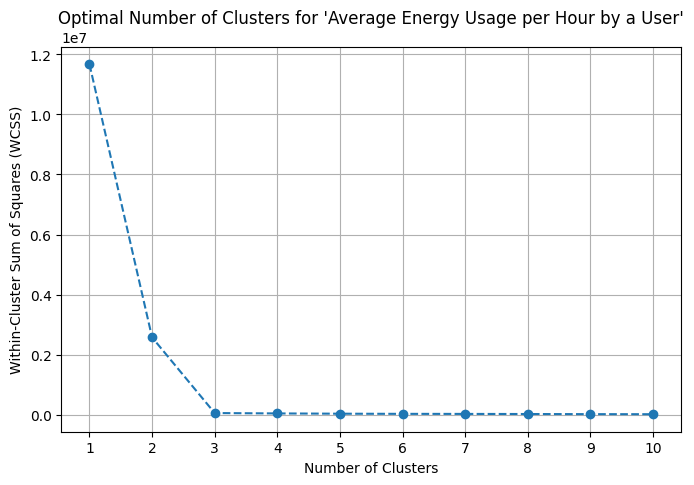

In [100]:
print_elbow_plot(summary_ratio_std_df, "'Average Energy Usage per Hour by a User'")

Compute k-means

In [109]:
from matplotlib.ticker import MaxNLocator, FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def seconds_to_hhmm(seconds):
    """Converts seconds into hh:mm format."""
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    return f"{hours:02}:{minutes:02}"

def print_kmeans(df, scaled_df, n_clusters, x_name, y_name, x_label, y_label, title):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model and predict clusters
    df['Cluster'] = kmeans.fit_predict(scaled_df)

    # Ensure scaled_df is a NumPy array for ClusteringMetric
    scaled_array = scaled_df.to_numpy()
    
    # Compute Silhouette Score
    silhouette_avg = silhouette_score(scaled_array, df['Cluster'].values)
    
    # Scatter plot with KMeans clusters
    plt.figure(figsize=(14, 6))  # Increased width to 14 to make it wider
    
    sns.scatterplot(
        x=df[x_name],
        y=df[y_name],
        hue=df['Cluster'],
        palette=sns.color_palette(),  # Clearer color palette
        s=15,
        alpha=0.5
    )

    # Format the y-axis from seconds to hh:mm
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: seconds_to_hhmm(x)))
    
    # Set ticks for each hour (0 to 23)
    ticks = [i * 3600 for i in range(24)]  # Create ticks at 0, 1, 2, ..., 23 hours
    ax.set_xticks(ticks)  # Set these as the x-tick positions
    
    # Rotate the x-axis ticks for better readability
    plt.xticks(rotation=45)  # Adjust the rotation angle as needed (45 degrees in this case)
    
    # Adjust bottom space to accommodate the scores
    plt.subplots_adjust(bottom=0.25)  # Increase bottom margin

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add DBCV and Silhouette scores below the X-axis
    plt.figtext(
        0.6, 0.05,  # Position at the center and near the bottom
        f"Silhouette Score: {silhouette_avg:.2f}", 
        wrap=True, horizontalalignment='center', fontsize=12, color='black'
    )

    # Move legend to the bottom left corner outside the plot
    plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(0, -0.2), ncol=n_clusters)

    # Show the plot
    plt.show()


/tmp/ipykernel_3328/897697003.py:29: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


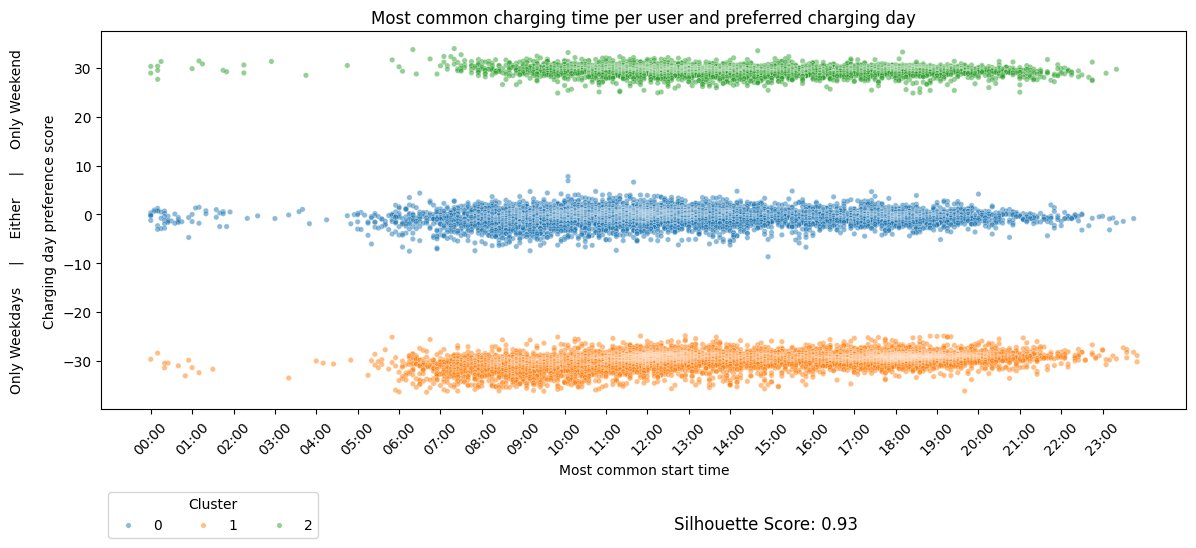

In [111]:
print_kmeans(df=summary_ratio_df,
             scaled_df=summary_ratio_std_df,
             n_clusters=3,
             x_name="Mode Start Time (seconds)",	
             y_name="Charging day preference score",
             x_label="Most common start time",
             y_label="Only Weekdays     |     Either     |     Only Weekend\n\n"
                     "Charging day preference score",
             title="Most common charging time per user and preferred charging day")

There's 3 distinct clusters that group users into their preferred charging period.

On the X axis, as you go further out from the center, the longer a user had a car connected to the charging station.

For the middle and bottom cluster, there seem to be considerably more users charging in the first part of the day comporated to the top cluster.

It makes sense as during the weekend, the users might wake up later or not be in the city area if they only work but not live there.
Also, there's less exclusive weekend users overall.

The Silhouette Score is near 1 and indicates a good separation of clusters.

In [ ]:
import json

with open('../notebook_to_review.ipynb') as json_file:
    data = json.load(json_file)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print(wordCount)